In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# jabref

In [4]:
from numpy import loadtxt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

Betöltöm a kontinuum PCA együtthatókat

In [5]:
PCs=numpy.load('./PCAfeldolgozas/PCs.npy')

Betöltöm az emissziós PCA együtthatókat

In [6]:
PCemiss=numpy.load('./PCAfeldolgozas/PCsemiss.npy')

A fehérítés lépést nem szabad kifelejteni

In [7]:
eig5=numpy.load('./PCAfeldolgozas/eig5.npy')

In [8]:
szorasok=numpy.std(eig5,axis=1)
print(szorasok)

[ 0.01396447  0.01205188  0.01402049  0.01389697  0.01394858]


In [9]:
PCsfeher=numpy.empty((5,13787))
for j in range (0,5):
    for i in range (0,13787):
        PCsfeher[j,i]=PCs[j,i]/szorasok[j]

In [10]:
PCsfehT=PCsfeher.T

Elvégzem újra erre a 40-es klaszterezést

In [11]:
kmeans=KMeans(n_clusters=40).fit(PCsfehT)
labels40=kmeans.labels_
centr40=kmeans.cluster_centers_
numpy.save('./PCAfeldolgozas/finlabels40.npy',labels40)
numpy.save('./PCAfeldolgozas/fincenters40.npy',centr40)

In [12]:
atlagsp=numpy.load('./PCAfeldolgozas/atlagspektrum.npy')

A sajátspektrumok már megvannak, ki kell fejteni a bemeneti templatet ezen a bázison, majd meg kell nézni melyik centroidhoz esik a legközelebb

# Template kifejtése a PCA térben

In [13]:
spektra={}
content=loadtxt('./SDSS/Composites/Tblu1.txt')
kompozit=content[:,[0,4]]
spektra[0]=kompozit
i=1

In [14]:
eig=eig5.T

Le kell normálni a kompozitot, itt igazából csak azt csinálom, amit a PCAKifejtes programban

In [15]:
for j in range (0,i):
    temp=spektra[j]
    m1=0
    m2=0
    m3=0
    m4=0
    n=0
    for k in temp[:,0]:
        if(k>4250 and k<4300):
            if(m1==0):
                normalashoz1=temp[n,1]
                m1+=1
            else:
                normalashoz1=numpy.append(normalashoz1,temp[n,1])
                
        if(k>4600 and k<4800):
            if(m2==0):
                normalashoz2=temp[n,1]
                m2+=1
            else:
                normalashoz2=numpy.append(normalashoz2,temp[n,1])
                
        if(k>5400 and k<5500):
            if(m3==0):
                normalashoz3=temp[n,1]
                m3+=1
            else:
                normalashoz3=numpy.append(normalashoz3,temp[n,1])
                
        if(k>5600 and k<5800):
            if(m4==0):
                normalashoz4=temp[n,1]
                m4+=1
            else:
                normalashoz4=numpy.append(normalashoz4,temp[n,1])
                
        n+=1
        
    med1=numpy.median(normalashoz1)
    med2=numpy.median(normalashoz2)
    med3=numpy.median(normalashoz3)
    med4=numpy.median(normalashoz4)
    avgmed=(med1+med2+med3+med4)/4
        
    temp[:,1]=temp[:,1]/avgmed
    spektra[j]=temp
    del temp

Most újra kell mintavételeznem, most még ugyanakkora tartományra mint amin a PCA is futott, ez a kifejtési együtthatókhoz kell, később nem ezzel az újramintavételezettel fogok dolgozni

In [16]:
def interpol(x1,x2,y1,y2,xk):
    a=(y2-y1)/(x2-x1)
    b=y1-x1*(y2-y1)/(x2-x1)
    
    yx=a*xk+b
    
    return(yx)

In [17]:
mintapontok=linspace(3724,6760.6,5062)
nullak=linspace(0,0,5062)

In [18]:
umspektra={}          # ezt a példányt meghagyom a mintavételezésre, bár gyorsabb lenne a nyumpy-os interpoláció
for j in range (0,i):
    umspektrum=numpy.vstack((mintapontok,nullak)).T
    temp=spektra[j]
    v=0
    w=0
    for q in range (0,5062):
        xk=mintapontok[q]
        while(temp[w,0]<6760.6):
            if(xk>temp[w,0] and xk<temp[w+1,0]):
                yk=interpol(temp[w,0],temp[w+1,0],temp[w,1],temp[w+1,1],xk)
                umspektrum[v,0]=xk
                umspektrum[v,1]=yk
                v+=1
                break
            if(xk==temp[w,0]):
                umspektrum[v,0]=xk
                umspektrum[v,1]=temp[w,1]
                v+=1
                break
            if(xk==temp[w+1,0]):
                umspektrum[v,0]=xk
                umspektrum[v,1]=temp[w+1,1]
                v+=1
                break
            w+=1
    del temp
    umspektra[j]=umspektrum
    del umspektrum

(3700, 6500)

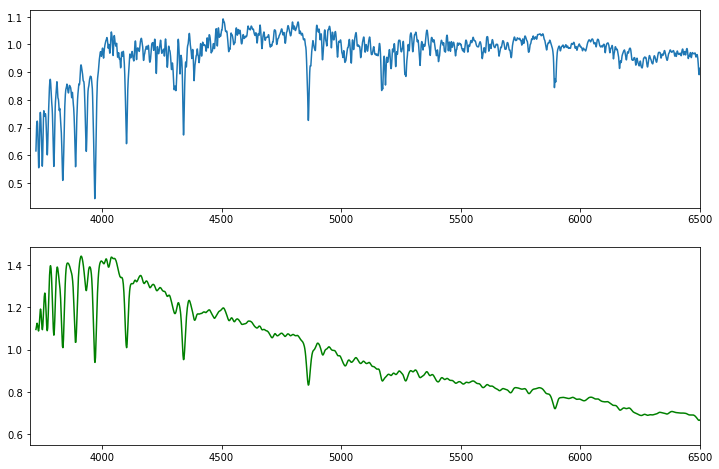

In [19]:
figsize(12,8)
temp=umspektra[0]
figure(1)
plt.subplot(211)
plot(atlagsp[:,0],atlagsp[:,1])
xlim(3700,6500)
plt.subplot(212)
plot(temp[:,0],temp[:,1],'g')
xlim(3700,6500)

In [20]:
red_umspektra={}
for j in range (0,i):
    temp=umspektra[j]
    for k in range (0,5062):
        temp[k,1]=temp[k,1]-atlagsp[k,1]
    red_umspektra[j]=temp
    del temp
del umspektra

In [21]:
Trafomtx=numpy.dot(eig.T,eig)
print(Trafomtx)

[[  1.00000000e+00   4.23272528e-16  -2.67147415e-16   3.43475248e-16
    1.86916455e-16]
 [  4.23272528e-16   1.00000000e+00  -3.57353036e-16  -5.68121938e-16
   -2.46764414e-16]
 [ -2.67147415e-16  -3.57353036e-16   1.00000000e+00   7.27716498e-16
   -3.43692089e-16]
 [  3.43475248e-16  -5.68121938e-16   7.27716498e-16   1.00000000e+00
   -4.85288892e-16]
 [  1.86916455e-16  -2.46764414e-16  -3.43692089e-16  -4.85288892e-16
    1.00000000e+00]]


In [22]:
Kifejteseh={}
for j in range (0,i):
    temp=red_umspektra[j]
    A=numpy.dot(inv(Trafomtx),eig.T)
    PC=numpy.dot(A,temp[:,1])
    Kifejteseh[j]=PC
    del PC
    del temp
    del A

# Kontinuumok legenerálása a középpontokra

Legenerálom az egyes középpontokra a kontinuumokat

In [23]:
centr=centr40.T         # most az oszlopokban lesznek az egyes centrumokhoz tartozó együtthatók
for j in range (0,5):
    for i in range (0,40):
        centr[j,i]=centr[j,i]*szorasok[j]

In [24]:
kpspektra={}
for i in range (0,40):
    spektrum=numpy.empty((5062,2))
    temp=centr[:,i]
    spektrum[:,0]=mintapontok[:]
    spektrum[:,1]=numpy.dot(eig,temp)+atlagsp[:,1]
    kpspektra[i]=spektrum
    del spektrum
    del temp

Ábrázolom az egyiket a biztoság kedvéért

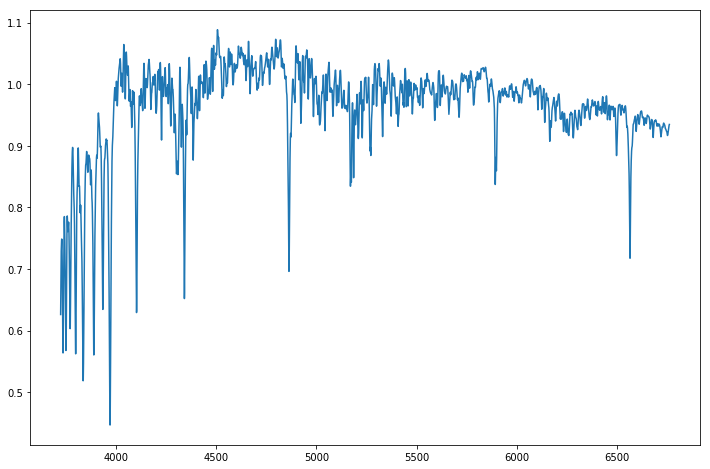

In [25]:
temp=kpspektra[0]
plot(temp[:,0],temp[:,1])
del temp

# Kovarianciamátrix, kék galaxis választása

Ezek után kéne a kovarianciamátrixokat összehozni. Ehhez kellenek az egyes klaszterekhez tartozó pontok külön külön, szóval szortírozni kell a labelek szerint.

In [26]:
lab_emiss=numpy.empty((11,13787))        # hány sora van és hány oszlopa
lab_emiss[0,:]=labels40[:]               # első sorban vannak az indexek, tehát az oszlopok tartoznak a különálló gx-okhoz
lab_emiss[1:11,:]=PCemiss[:,:] 

In [27]:
kpemi={}                 # a dictionary egyes logjai az egyes középpont környezetébe eső pontok lesznek emissziós vonalak terében
for i in range (0,40):
    n=0
    for j in range (0,13787):
        if(lab_emiss[0,j]==i):
            n+=1
    temp=numpy.empty((10,n))
    m=0
    for j in range (0,13787):
        if(lab_emiss[0,j]==i):
            temp[:,m]=lab_emiss[1:11,j]
            m+=1
    kpemi[i]=temp
    del temp

Akkor tehát megvan a szortírozás, az egyes kontinuumok is, tehát már csak le kell generálni az egyes kovarianciamátrixokat, majd a véletlen számokat kell keresgélni, **NE FELEDD,** az oszlopokban vannak az egyes galaxisokhoz tartozó együtthatók

In [28]:
kovarianc={}
means={}
for i in range (0,40):
    temp=kpemi[i]
    meant=numpy.mean(temp,axis=1)
    temp -= temp.mean(axis=1)[:, None]
    covi=numpy.cov(temp)
    kovarianc[i]=covi
    means[i]=meant
    del covi
    del temp
    del meant
numpy.save('./PCAfeldolgozas/klaszt_means.npy',means)
numpy.save('./PCAfeldolgozas/klaszt_kovar.npy',kovarianc)

Most kéne egy kék galaxist választani. Ehhez plottolom a galaxisokat az első két főkomponensükkel asszerint színezve, mennyire kékek

In [28]:
PCs=PCs.T
elso2=PCs[:,0:2]

A következő fájlban vannak ezek lementve, beolvasom, majd kiveszem a g és r sávhoz tartozó magnikat, ezeket kivonom egymásból, lenormálom és ezt próbálom majd színkódolni

In [29]:
data=loadtxt('emisslines.txt')
gr=numpy.empty((13787,2))
gr[:,0]=data[:,2]
gr[:,1]=data[:,3]

In [30]:
g_r=numpy.empty((13787,1))
g_r[:,0]=gr[:,0]-gr[:,1]

In [31]:
normgr=g_r[:,0]
maxim=max(g_r[:,0])
s=100/maxim
normgr=s*normgr
print(normgr)

[ 10.79141573   6.94376113  22.67028586 ...,  16.73085079   7.80218848
   6.83009585]


In [32]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'brg'

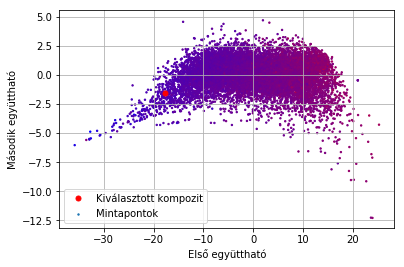

In [33]:
figsize(6,4)
x=elso2[:,0]
y=elso2[:,1]
plt.scatter(x,y,c=normgr,s=2,label='Mintapontok')
grid(True)
temp=Kifejteseh[0]
plot(temp[0],temp[1],'ro',ms=5,label='Kiválasztott kompozit')
xlabel('Első együttható')
ylabel('Második együttható')
plt.legend()
savefig('kekules.pdf', bbox_inches='tight')
# plot(centr[0,33],centr[1,33],'bo',ms=5)

Pár pontra amit kiprinteltem megnéztem, ha kisebb az első két együttható, akkor nagyobb a g-r, azaz kékebb lesz a galaxis. Tehát nekünk az a centroid kell, aminek az első eh-ja <-10 és a második < 0. Ha megnézem a korábbi ábrázolgatásokat, akkor kb 5-6 ilyen centroid van

In [34]:
#for i in range (0,40):
#    if(centr[0,i]<(-10) and centr[1,i]<0):
#        print(i)

Tehát akkor most ezt a kontinuumot kell majd nyúzni egy kicsit: erre kell majd vonalakat generálni, meg nézni a szín szín diagramot. Először megcsinálom azt, hogy generálok rá vonalakat, majd azt tologatom el, és majd ez után próbálom meg azt, hogy minden redshiften új vonalakat dobálok rá.

# Legközelebbi szomszéd keresése a templatehez

In [35]:
tavolsagok={}
for l in range (0,40):
    tavolsagok[l]=0
    temp=0
    teh=Kifejteseh[0]
    for m in range (0,5):
        temp+=(teh[m]-centr[m,l])**2
    tavolsagok[l]=sqrt(temp)
    del temp
minimal=30
for l in range (0,40):
    temp=tavolsagok[l]
    if(temp<minimal):
        minimal=temp
        I=l
    del temp
print(I)
ind=I
del I

25


Ezzel tehát megvan a legközelebbi centroid indexe, már csak az kell, hogy ehhez generáljuk a vonalakat.

# Vonalak generálása

Első körben akkor random generálok vonalakat

In [36]:
cov=kovarianc[ind]
avg=means[ind]
vonaleh=numpy.random.multivariate_normal(avg,cov)
print(vonaleh)

[-7.26025005  2.15261502  0.3786761   0.37741699 -0.07758618  0.20882916
  0.29527452 -0.01063263  0.3285899   0.02627664]


In [37]:
#vonaleh=avg
#print(avg)

In [38]:
V=numpy.load('./PCAfeldolgozas/EmissV.npy')
atlag=numpy.load('./PCAfeldolgozas/emissatlag.npy')

Igazából ide csak bekopiztam a már megírt programomat, kicsit értelmesebb változóelnevezéssel

In [39]:
logEWred=numpy.dot(V.T,vonaleh)
logEWk=logEWred+atlag[:,1]

Exponencializáljuk a log(EW)-ket

In [40]:
EW=numpy.exp(logEWk)

In [41]:
lambd=[3727,4342,4863,4960,5008,6550,6565,6585,6718,6733]

In [42]:
from scipy.integrate import quad

A kontinuum nem a középponti spektrum lesz, hanem a template.

In [43]:
# print(kompozit)

In [44]:
for j in range (0,1):
    temp=kompozit
    m1=0
    m2=0
    m3=0
    m4=0
    n=0
    for k in temp[:,0]:
        if(k>4250 and k<4300):
            if(m1==0):
                normalashoz1=temp[n,1]
                m1+=1
            else:
                normalashoz1=numpy.append(normalashoz1,temp[n,1])
                
        if(k>4600 and k<4800):
            if(m2==0):
                normalashoz2=temp[n,1]
                m2+=1
            else:
                normalashoz2=numpy.append(normalashoz2,temp[n,1])
                
        if(k>5400 and k<5500):
            if(m3==0):
                normalashoz3=temp[n,1]
                m3+=1
            else:
                normalashoz3=numpy.append(normalashoz3,temp[n,1])
                
        if(k>5600 and k<5800):
            if(m4==0):
                normalashoz4=temp[n,1]
                m4+=1
            else:
                normalashoz4=numpy.append(normalashoz4,temp[n,1])
                
        n+=1
        
    med1=numpy.median(normalashoz1)
    med2=numpy.median(normalashoz2)
    med3=numpy.median(normalashoz3)
    med4=numpy.median(normalashoz4)
    avgmed=(med1+med2+med3+med4)/4
        
    temp[:,1]=temp[:,1]/avgmed
    Kontinuum=temp
    del temp

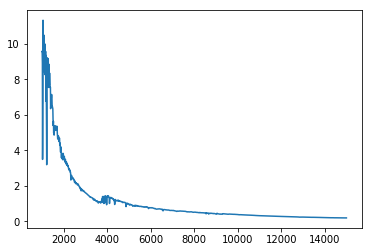

In [45]:
plot(Kontinuum[:,0],Kontinuum[:,1])

In [46]:
# print(Kontinuum)

In [47]:
mintapontok=linspace(1001,14999,27997)
# nullak=linspace(0,0,27997)

In [48]:
temp=Kontinuum
umspektrum=numpy.interp(mintapontok,temp[:,0],temp[:,1])  # a mintavételezésre immáron a numpy-os interpolációt használom
Kontinuum_res=numpy.vstack((mintapontok,umspektrum)).T
del temp

In [49]:
UmSp={}
UmSp[0]=Kontinuum_res
Spektrum=Kontinuum_res
print(Kontinuum_res)

[[  1.00100000e+03   9.55959132e+00]
 [  1.00150000e+03   9.56183957e+00]
 [  1.00200000e+03   9.56408783e+00]
 ..., 
 [  1.49980000e+04   1.94549224e-01]
 [  1.49985000e+04   1.94549224e-01]
 [  1.49990000e+04   1.94549224e-01]]


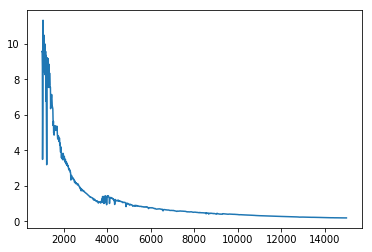

In [50]:
plot(Kontinuum_res[:,0],Kontinuum_res[:,1])

A vonalak legyártása a következő lépésben történik

In [51]:
tempK=UmSp[0]
def integrand(x, sig, l0):
    return(numpy.exp(-(x-l0)**2 / (2*sig**2)))

nminta=27997                  # mintavételezési helyek száma
sigma=200                     # gx sebsségdiszperziója  <----- EZ MÉG MINDIG CSAK EGY ÖNKÉNYES PARAMÉTER

Emiss={}                      # dictionary az emissziós vonalak tárolására

for j in range (0,10):
    l0=lambd[j]                   # emissziós vonal hullámhossza
    dellambd=l0*sigma/300000
    l1=l0-dellambd                # alsó integrálási határ
    l2=l0+dellambd                # felső integrálási határ
    sig=(l2-l0)/3                 # Gauss szórása
    W=EW[j]

    I=quad(integrand, l1, l2, args=(sig, l0))    # Gauss integrál számolása

    integ=I[0]                                   # quad több értékkel tér vissza, ebből veszem az elsőt

    F0=0
    w=0
    for q in range (0,nminta):
        if(tempK[q,0]>l1 and tempK[q,0]<l2):         # számolok egy átlagkontinuumot a vonal környezetében (a vonal alatt)
            F0+=tempK[q,1]
            w+=1
    
    F0=F0/w
    print(l1, l2)
    print(F0, w)

    a=F0*W/integ                   # Gauss együtthatója

    Flamb=numpy.empty((1000,1))                                 # kiszámolom a csúcs fluxusait
    lamb=linspace(l1,l2,1000)
    for i in range (0,1000):
        Flamb[i]=F0+a*numpy.exp(-(lamb[i]-l0)**2 / (2*sig**2))
    
    vonal=numpy.empty((1000,2))
    vonal[:,0]=lamb[:]
    vonal[:,1]=Flamb[:,0]

    d=0
    for q in range (0,nminta):                                 # hány mintavételezési pont esik a vonal alá
        if(mintapontok[q]>l1 and mintapontok[q]<l2):
            d+=1
    temp=vonal
    v=0
    umvon_int=numpy.interp(mintapontok,temp[:,0],temp[:,1])
    
    t=0  
    for q in range (0,nminta):                               # ráteszem a vonalat a spektrumra
        if(tempK[q,0]>l1 and tempK[q,0]<l2):
            Spektrum[q,1]+=umvon_int[t]
            t+=1      
        
    umvonal=numpy.vstack((mintapontok,umvon_int)).T
    Emiss[j]=umvonal
    del temp
    del vonal
    del umvonal
    del umvon_int
del tempK

temp=Kontinuum
umspektrum=numpy.interp(mintapontok,temp[:,0],temp[:,1])
Kontinuum_res=numpy.vstack((mintapontok,umspektrum)).T
del temp

3724.5153333333333 3729.4846666666667
1.11607948285 9
4339.105333333333 4344.894666666667
0.959733479281 11
4859.758 4866.242
0.8380120791 13
4956.693333333334 4963.306666666666
0.999502308788 13
5004.6613333333335 5011.3386666666665
0.938195975042 13
6545.633333333333 6554.366666666667
0.648268180395 17
6560.623333333333 6569.376666666667
0.593954391229 17
6580.61 6589.39
0.658204597319 17
6713.521333333333 6722.478666666667
0.644453489722 17
6728.511333333333 6737.488666666667
0.645229359011 17


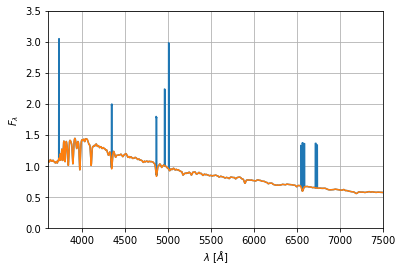

In [55]:
temp=UmSp[0]
figsize(6,4)
plot(Spektrum[:,0],Spektrum[:,1],label='Vonalakkal kiegészített spektrum')
plot(Kontinuum_res[:,0],Kontinuum_res[:,1],label='Kontinuum')
grid(True)
xlim(3600,7500)
ylim(0,3.5)
xlabel('$\lambda$ [$\AA$]')
ylabel('$F_{\lambda}$')
savefig('1blu_rand.pdf', box_inches='tight')

In [122]:
# numpy.savetxt('./vonalak.txt',Spektrum,delimiter='\t',newline='\n')

In [123]:
print(kompozit)

[[  1.00100000e+03   9.55959132e+00]
 [  1.00300000e+03   9.56858435e+00]
 [  1.00500000e+03   9.57757738e+00]
 ..., 
 [  1.49950000e+04   1.94549224e-01]
 [  1.49970000e+04   1.94549224e-01]
 [  1.49990000e+04   1.94549224e-01]]


Most már rajta vannak a vonalak, most kell behozni azt a programot amit C-ben írtam

# Magnitúdók számolása az egyes szűrőkkel

Először betöltjük mind az öt szűrő átersztési görbéjét, nem számít, hogy esetleg csak kettőt használunk majd belőlük.

In [1]:
import os
import codecs

In [5]:
indir = './SDSS/Filters'
szurok={}
for root, dirs, filenames in os.walk(indir):
    i=0
    for f in filenames:
        filecp = codecs.open(os.path.join(root, f), encoding = 'cp1252')
        content = loadtxt(filecp)
        array=content
        szurok[i]=array
        i+=1
        del content
        del array
# print(szurok)

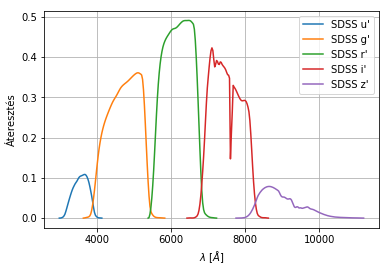

In [7]:
figsize(6,4)
temp=szurok[3]
plot(temp[:,0],temp[:,1],label='SDSS u\'')
temp=szurok[0]
plot(temp[:,0],temp[:,1],label='SDSS g\'')
temp=szurok[1]
plot(temp[:,0],temp[:,1],label='SDSS r\'')
temp=szurok[2]
plot(temp[:,0],temp[:,1],label='SDSS i\'')
temp=szurok[4]
plot(temp[:,0],temp[:,1],label='SDSS z\'')
plt.legend()
grid(True)
xlabel('$\lambda$ [$\AA$]')
ylabel('Áteresztés')
savefig('szurok.pdf', box_inches='tight')

Most igazából az egész lényege: egy nagy while ciklusban rámintavételezem a szűrőt az eltolt spektrumra, majd kiszámolom az egyes fluxusokat.

In [127]:
temp=szurok[4]
temp.shape

(139, 2)

In [128]:
from scipy.integrate import trapz

In [129]:
# errorok miatt kénytelen voltam kézzel beadni az egyes szűrők elemszámát, próbáltam már elgé sok mindent...
umszurok={}
elemszam=[89,75,89]
z=0.0
u=0
Smagnik=numpy.empty((71,4))
Kmagnik=numpy.empty((71,4))
while(z<0.71):
    Smagnik[u,0]=z
    Kmagnik[u,0]=z
    Spekz=numpy.empty((27997,2))
    Kontiz=numpy.empty((27997,2))
    for q in range (0,27997):
        Spekz[:,0]=(1.0+z)*Spektrum[:,0]           # vöröseltolódást szenvedett spektrum
        Spekz[:,1]=Spektrum[:,1]                   # fluxusok ua-zok, csak odébb lettek tolva
        Kontiz[:,0]=(1.0+z)*Kontinuum_res[:,0]
        Kontiz[:,1]=Kontinuum_res[:,1]
    
    # most kell újramintavételezni a szűrőt, ehhez behozom a már korábban megírt scriptet, mindegyik szűrőt újramintavételezem
    
    for j in range (0,3):       
        temp=szurok[j]
        umszuro_at=numpy.interp(Spekz[:,0],temp[:,0],temp[:,1])

        umszuro=numpy.vstack((Spekz[:,0], umszuro_at)).T
        umszurok[j]=umszuro
        
        vi=0
        for w in range (0,27997):
            if(umszuro_at[w]>0):
                    wk=w-vi
                    vi+=1
                    
        Spekzr=Spekz[wk:wk+vi,:]
        umszuror=umszuro[wk:wk+vi,:]
        Kontizr=Kontiz[wk:wk+vi,:]
        
    # ezekre az elnevezésekre semmi szükség, csak az ellenőrzések miatt neveztem el őket külön, aztán így maradtak...
    
    # azért van ennyi elnevezés, mert egyszerre akarom a futtatást a kontinuumra és a vonalas spektrumra
        Stempsz=numpy.multiply(Spekzr[:,1],umszuror[:,1])
        Stempsz2=numpy.multiply(Stempsz,Spekzr[:,0])
        Stempsz2=Stempsz2.tolist()
        Stemplist=[1/x for x in Spekzr[:,0]]
        Stempsz3=numpy.multiply(umszuror[:,1],Stemplist)
        Stempsz3=Stempsz3.tolist()
        
        Ktempsz=numpy.multiply(Kontizr[:,1],umszuror[:,1])
        Ktempsz2=numpy.multiply(Ktempsz,Kontizr[:,0])
        Ktempsz2=Ktempsz2.tolist()
        Ktemplist=[1/x for x in Kontizr[:,0]]
        Ktempsz3=numpy.multiply(umszuror[:,1],Ktemplist)
        Ktempsz3=Ktempsz3.tolist()
        
        Sszamlalo=trapz(Stempsz2,x=Spekzr[:,0])
        Snevezo=trapz(Stempsz3,x=Spekzr[:,0])
            
        Kszamlalo=trapz(Ktempsz2,x=Kontizr[:,0]) 
        Knevezo=trapz(Ktempsz3,x=Kontizr[:,0])
        
        Sflux=Sszamlalo/Snevezo
        Kflux=Kszamlalo/Knevezo
        
        Smab=-2.5*numpy.log10(Sflux)-48.60
        Kmab=-2.5*numpy.log10(Kflux)-48.60
        
        Smagnik[u,j+1]=Smab
        Kmagnik[u,j+1]=Kmab
        
    u+=1
    z+=0.01

In [130]:
#for j in range (0,3):
#    temp=umszurok[j]
#    plot(temp[:,0],temp[:,1])
#    del temp

In [131]:
# print(Kmagnik)

# GRv=magnik[:,1]-magnik[:,2]
# RIv=magnik[:,2]-magnik[:,3]

In [132]:
#gkont=loadtxt('./1starg_kont.dat')
#rkont=loadtxt('./1starr_kont.dat')
#ikont=loadtxt('./1stari_kont.dat')
#gvon=loadtxt('./g1star_em.dat')
#rvon=loadtxt('./r1star_em.dat')
#ivon=loadtxt('./i1star_em.dat')

In [133]:
#GRv=gvon[:,1]-rvon[:,1]
#RIv=rvon[:,1]-ivon[:,1]
#GRk=gkont[:,1]-rkont[:,1]
#RIk=rkont[:,1]-ikont[:,1]

In [134]:
GRv=Smagnik[:,1]-Smagnik[:,2]
RIv=Smagnik[:,2]-Smagnik[:,3]
GRk=Kmagnik[:,1]-Kmagnik[:,2]
RIk=Kmagnik[:,2]-Kmagnik[:,3]

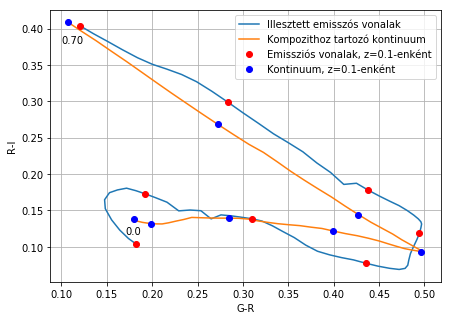

In [142]:
figsize(7,5)
emi=plot(GRv,RIv,label='Illesztett emisszós vonalak')
konti=plot(GRk,RIk,label='Kompozithoz tartozó kontinuum')
grid(True)
emi10=plot(GRv[0],RIv[0],'ro',label='Emissziós vonalak, z=0.1-enként')
konti10=plot(GRk[0],RIk[0],'bo',label='Kontinuum, z=0.1-enként')
for r in range (1,8):
    plot(GRv[10*r],RIv[10*r],'ro')
    plot(GRk[10*r],RIk[10*r],'bo')
xlabel('G-R')
ylabel('R-I')
plt.legend()
text(0.17, 0.117, u'0.0')
text(0.1,0.38, u'0.70')
savefig('1blu_szin.pdf', bbox_inches='tight')

In [66]:
interpolate, elemenkénti szorzás, scipy integrate trapz

SyntaxError: invalid syntax (<ipython-input-66-2335eb624585>, line 1)